**Import dependencies or data **

In [ ]:
!pip install tensorflow  matplotlib tensorflow-datasets ipywidgets

In [1]:
import tensorflow as tf

# List all physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

# Set memory growth for each GPU
for gpu in gpus:
    # Set memory growth before initializing the GPU
    tf.config.experimental.set_memory_growth(gpu, True)



In [ ]:
!pip list


In [2]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [63]:
ds = tfds.load('oxford_flowers102',split = 'train[:60%]')

In [26]:
ds.as_numpy_iterator().next()['label']

72

In [ ]:
ds.as_numpy_iterator().next()['image']

Visualize data and build Data

In [47]:
import numpy as np
dataiterator = ds.as_numpy_iterator()

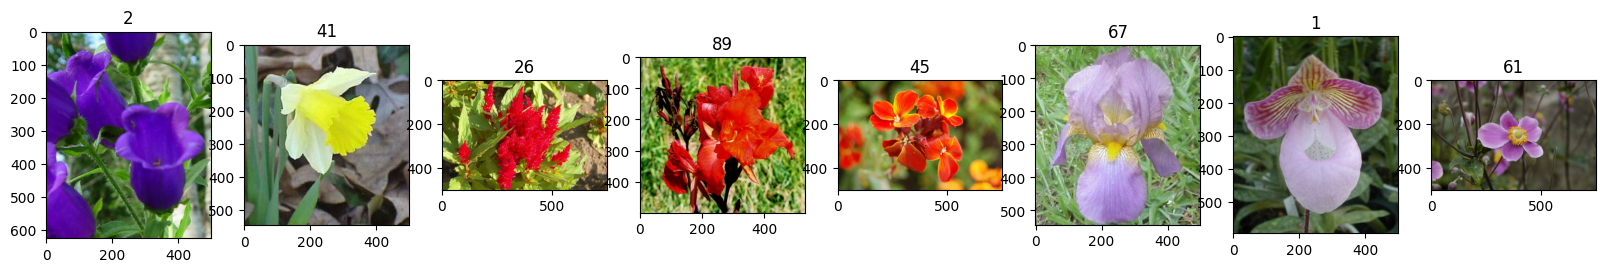

In [64]:
#Plot a sample
fig, ax = plt.subplots(ncols=8,figsize =(20,20))
for idx in range(8):
  sample = dataiterator.next()
  ax[idx].imshow(np.squeeze(sample['image']))
  ax[idx].title.set_text(sample['label'])

In [65]:
def resize_images(data):
    image = data['image']
    resize_images = tf.image.resize(image, (28, 28))
    return resize_images

def normalize_images(data):
  return data/255

def grayscale_images(data):
  return tf.image.rgb_to_grayscale(data)


In [66]:
# Map the 'scale, resize and grayscale' function to each element of the dataset
ds = ds.map(resize_images)
ds = ds.map(grayscale_images)
ds = ds.map(normalize_images)

# Cache the dataset to speed up subsequent iterations
ds = ds.cache()

# Shuffle the dataset with a buffer size of 60000
ds = ds.shuffle(60000)

# Create batches of size 128
ds = ds.batch(128)

# Prefetch 64 batches to optimize data loading
ds = ds.prefetch(64)


In [67]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [68]:
ds.as_numpy_iterator().next()

array([[[[0.04084583],
         [0.01421322],
         [0.02460097],
         ...,
         [0.27308565],
         [0.28729782],
         [0.12204753]],

        [[0.13996807],
         [0.11477621],
         [0.04364667],
         ...,
         [0.14546922],
         [0.26586226],
         [0.30948964]],

        [[0.15408218],
         [0.21657176],
         [0.1464841 ],
         ...,
         [0.12349962],
         [0.3422228 ],
         [0.26533362]],

        ...,

        [[0.13103758],
         [0.17053974],
         [0.20366968],
         ...,
         [0.3112911 ],
         [0.32481635],
         [0.31095496]],

        [[0.17730817],
         [0.20601417],
         [0.18214372],
         ...,
         [0.18774395],
         [0.29436117],
         [0.27166137]],

        [[0.22898112],
         [0.19010325],
         [0.1850007 ],
         ...,
         [0.08341937],
         [0.18608978],
         [0.30645907]]],


       [[[0.32366785],
         [0.6019719 ],
         [0.35

**Build the Neural Network**

3.1 Import Modelling components



3.2 Build Generator
3.3 Build Discrimnator


In [69]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout , UpSampling2D

In [70]:
def build_generator():
  model = Sequential()

  #Take in random values
  model.add(Dense(7*7*128,input_dim=128))
  model.add(LeakyReLU(0.2))
  #Reshape to 7x7x128
  model.add(Reshape((7,7,128)))

  #Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding = 'same'))
  model.add(LeakyReLU(0.2))

  #Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding = 'same'))
  model.add(LeakyReLU(0.2))

  #Down sampling block 1
  model.add(Conv2D(128,4,padding = 'same'))
  model.add(LeakyReLU(0.2))

  #Down sampling block 2
  model.add(Conv2D(128,4,padding = 'same'))
  model.add(LeakyReLU(0.2))

   #Conv layer to get one channel
  model.add(Conv2D(1,4,padding = 'same',activation = 'sigmoid'))

  return model

In [89]:
generator= build_generator()
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 142ms/step


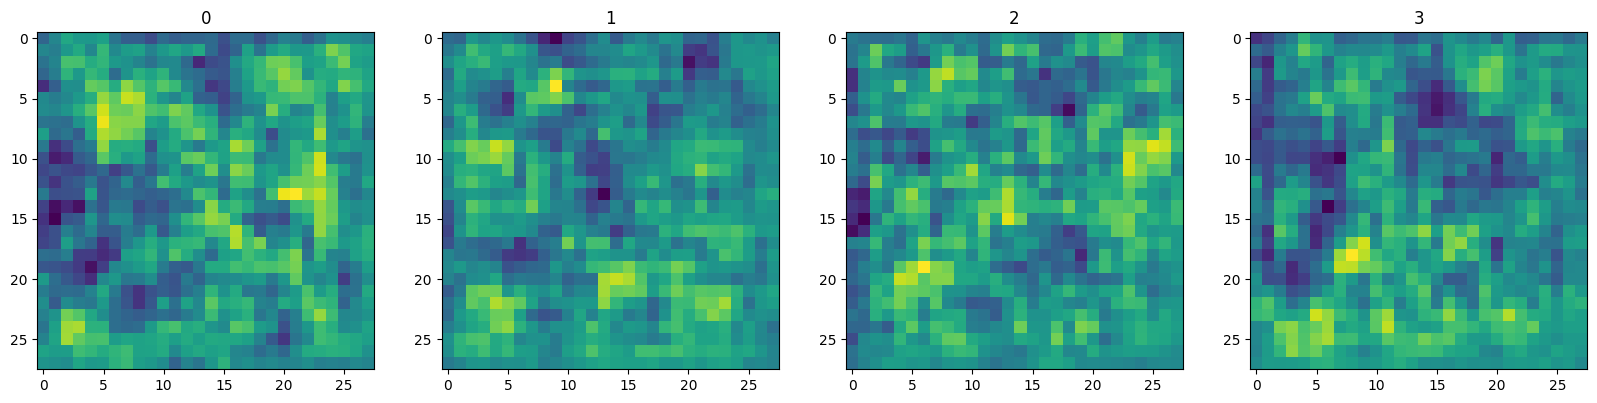

In [90]:
img = generator.predict(np.random.randn(4,128,1))
#Plot a sample
fig, ax = plt.subplots(ncols=4,figsize =(20,20))
for idx,img  in enumerate(img):

  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)


3.3 Build Discrimnator


In [91]:
def build_discriminator():
  model = Sequential()

  #1st Conv Block
  model.add(Conv2D(32,5,input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #2nd Conv Block
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #3rd Conv Block
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #4th Conv Block
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Flatten then pass to dense layer

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))
  return model

In [92]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 128)      

In [93]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

1/1 [==============================] - 0s 91ms/step


(4, 28, 28, 1)

In [94]:
discriminator.predict((img))

1/1 [==============================] - 0s 78ms/step


array([[0.5007819],
       [0.5007986],
       [0.5006583],
       [0.5006539]], dtype=float32)

**4.Construct Training Loop**


Setup Losses and Optimizers

In [95]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
g_opt = Adam(learning_rate= 0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [113]:
from tensorflow.keras.models import Model
class FlowersGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt,d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train discriminator
        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create Labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add noise to the outputs
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake +=   tf.concat([noise_real, noise_fake], axis=0)

            # Calculate Loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            # Apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)

            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": total_g_loss}


In [114]:
flowersGan = FlowersGAN(generator, discriminator)


In [115]:
flowersGan.compile(g_opt,d_opt, g_loss,d_loss)

In [100]:
from google.colab import drive
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import os

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your folder
folder_path = '/content/drive/MyDrive/Flowers'

# Check if the folder exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img_path = os.path.join(folder_path, f'generated_img_{epoch}_{i}.png')
            img.save(img_path)


Mounted at /content/drive


In [ ]:
history = flowersGan.fit(ds, epochs=1000, callbacks=ModelMonitor())


In [ ]:
plt.suptitle('Loss')
plt.plot(history.history['d_loss'], label='d_loss')
plt.plot(history.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

Test the model

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
for r in range(4):
    for c in range(4):
        ax[r, c].imshow(imgs[(r + 1) * (c + 1) - 1])
plt.show()